In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize

from sklearn.metrics import classification_report, accuracy_score, f1_score

np.random.seed(42)

DATASET_DIR = 'datasets/lego-minifigures/'
os.listdir(DATASET_DIR)

['index.csv',
 'test',
 'metadata.csv',
 'test.csv',
 'LICENSE',
 'star-wars',
 'harry-potter',
 'jurassic-world',
 'marvel']

## The data

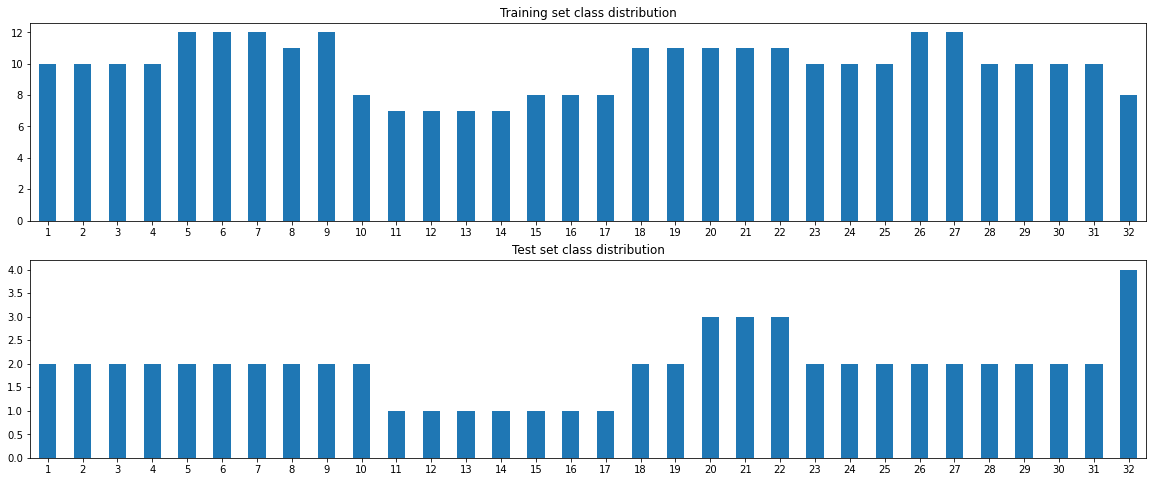

In [2]:
fig,ax = plt.subplots(2,1,figsize=(20,8))

index_df = pd.read_csv(os.path.join(DATASET_DIR,'index.csv'))
index_df.class_id.value_counts(sort=False).plot(kind='bar',rot=0,ax=ax[0],title='Training set class distribution');

metadata_df = pd.read_csv(os.path.join(DATASET_DIR,'metadata.csv'),index_col='class_id')
# metadata_df.head()

test_df = pd.read_csv(os.path.join(DATASET_DIR,'test.csv'))
test_df.class_id.value_counts(sort=False).plot(kind='bar',rot=0,ax=ax[1], title='Test set class distribution');
# fig.savefig('eda/class_dist.jpg',dpi=300)

### Sample images

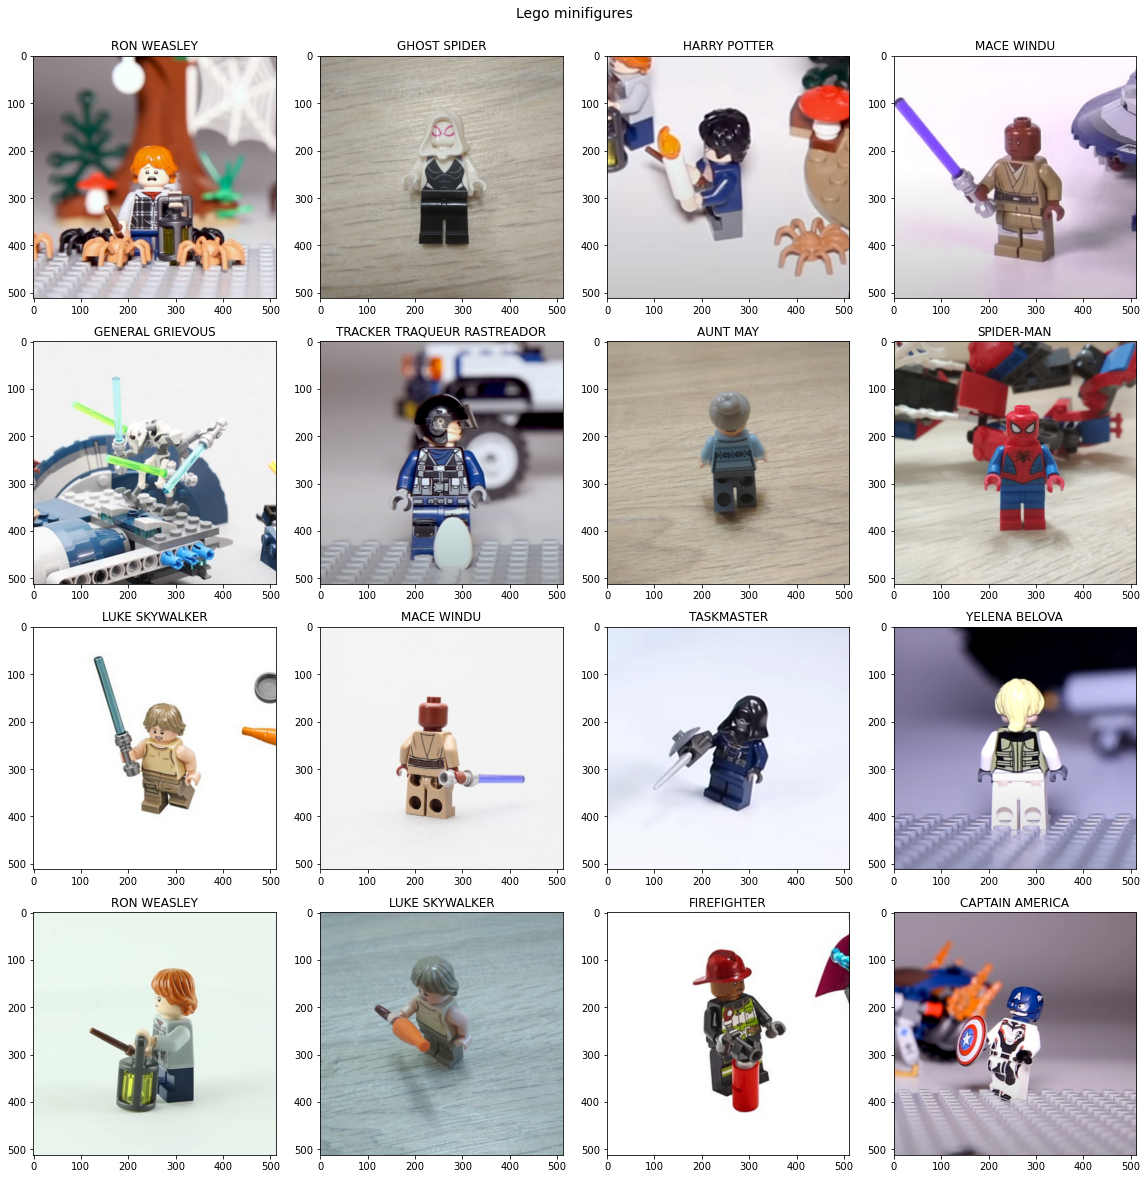

In [3]:
fig,axs = plt.subplots(4,4,figsize=(16,16))
fig.suptitle('Lego minifigures',y=1.02,fontsize=14)

random_indices = np.random.choice(index_df.index,16,replace=False)
for i in range(16):
    j = random_indices[i]
    img = io.imread(os.path.join(DATASET_DIR, index_df.loc[j,'path']))
    axs[i//4,i%4].imshow(img)
    axs[i//4,i%4].set_title(metadata_df.loc[index_df.loc[j,'class_id'],'minifigure_name'])

fig.tight_layout(pad=1.)

## Let's try some modeling

In [4]:
import albumentations
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from cv2 import BORDER_REPLICATE

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0')

batch_size=4
image_size = (512,512)

In [5]:
class LegoDataset(Dataset):
    
    def __init__(self, df, root_dir, image_size, transform=None, augment=None):

        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform
        self.image_size = image_size
        self.augment=augment
        
    def __len__(self):
        
        return len(self.annotations)
    
    def __getitem__(self, index):
        
        img_path  = os.path.join(self.root_dir, self.annotations.loc[index,'path'])
        image = io.imread(img_path)
        image  = resize(image,self.image_size)
#         image = cv2.imread(img_path)
#         image = cv2.resize(image, self.image_size)
#         image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        if self.augment:
            image = self.augment(image=image)['image']
        
        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(self.annotations.loc[index,'class_id']-1)
        return image, label

def transform_fn():
    return transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize(
             mean = [0.485, 0.456, 0.406],
             std = [0.229, 0.224, 0.225])
    ])

def augment_fn():
    return albumentations.Compose(
        [
            albumentations.Rotate(limit=30, border_mode=BORDER_REPLICATE, p=0.5),
            albumentations.Cutout(num_holes=8, max_h_size=20, max_w_size=20, fill_value=0,p=0.25),
            albumentations.Cutout(num_holes=8, max_h_size=20, max_w_size=20, fill_value=1,p=0.25),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.RandomContrast(limit=(-0.33,0.33),p=0.5),
            albumentations.RandomBrightness(limit=(-0.33,0.33),p=0.5),
            albumentations.RandomContrast(limit=(-0.33,0.33),p=0.5),
            albumentations.Blur(p=0.25)
        ], p=1.0
    )

In [6]:
train_dataset = LegoDataset(df=index_df, root_dir=DATASET_DIR, image_size=image_size,transform=transform_fn())
test_dataset = LegoDataset(df=test_df,root_dir=os.path.join(DATASET_DIR),image_size=image_size,transform=transform_fn())

train_loader = DataLoader(dataset= train_dataset, batch_size=batch_size, shuffle=True)
train_loader_no_shuffle = DataLoader(dataset= train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset= test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
def init_model_mobilenet_v2(n_classes):
    net = torch.hub.load("pytorch/vision:v0.6.0", "mobilenet_v2", pretrained=True)
    net.classifier = nn.Linear(
        in_features=1280, 
        out_features=n_classes, 
        bias=True,
    )
    return net

def train(train_loader, epoch, criterion, optimizer, device=device, verbose=0):
    model.train()
    train_loss, correct= 0,0
    for batch_id, (data,target) in enumerate(train_loader):
        data,target = data.to(device,dtype=torch.float), target.to(device)
        output = model(data)
        optimizer.zero_grad()
        
        loss = criterion(output,target)
        loss.backward()
        
        correct+=output.argmax(axis=1).eq(target).sum().item()
        train_loss+=loss.item()
        optimizer.step()

        if batch_id%1000==0 and verbose==1:
            print(f"Training epoch:{epoch} [{batch_id*len(data)}/{len(train_loader.dataset)}]"
                  f"{100.*batch_id/len(train_loader):.2f}%t Loss:{loss.item():.4f}")
            
    train_loss /= len(train_loader.dataset)
    acc = correct/len(train_loader.dataset)
        
    print(f"\nTrain: Average loss: {train_loss:.4f}\t Accuracy: {acc:.4f}")
    return train_loss,acc

def validate(model, test_loader,criterion, loader_name='Test', device=device):
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for data,target in test_loader:
            data,target=data.to(device, dtype=torch.float), target.to(device)
            output = model(data)
            test_loss += criterion(output,target).item()
            correct+=output.argmax(axis=1).eq(target).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = correct/ len(test_loader.dataset)
    
    print(f'{loader_name} set: Average loss: {test_loss:.4f}\t Accuracy: {acc:.4f}\n')
    return test_loss, acc

def training_loop(n_epochs,train_loader,test_loaders, optimizer, criterion, lr=1e-3,verbose=0,loader_name=['Test']):
    optimizer = optimizer(model.parameters(),lr=lr)
    criterion = criterion(reduction='mean')
    history = {'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    
    for epoch in range(n_epochs):
        print(f'epoch: {epoch}')
        loss,acc = train(train_loader,epoch,criterion,optimizer,device,verbose)
        history['train_loss'].append(loss)
        history['train_acc'].append(acc)
        for i,tl in enumerate(test_loaders):
            loss,acc = validate(model,tl,criterion,loader_name[i])
            history['val_loss'].append(loss)
            history['val_acc'].append(acc)
            
    return history

def predict(model, loader):
    model.eval()
    y_pred = []
    for data,_ in loader:
        data = data.to(device, dtype=torch.float)
        output = model(data)
        output = output.argmax(axis=1).detach().cpu().numpy()
        y_pred.extend(output)
    return np.expand_dims(np.array(y_pred),axis=1)

### Shuffle True

In [8]:
if 'model' in locals():
    del model
model = init_model_mobilenet_v2(32)
model.to(device)

optimizer = torch.optim.Adam
criterion = nn.CrossEntropyLoss

history = training_loop(10,train_loader,[test_loader], optimizer, criterion,lr=0.0001)

Using cache found in /home/eddiekro/.cache/torch/hub/pytorch_vision_v0.6.0


epoch: 0

Train: Average loss: 0.8195	 Accuracy: 0.0918
Test set: Average loss: 0.7882	 Accuracy: 0.2419

epoch: 1

Train: Average loss: 0.6274	 Accuracy: 0.4652
Test set: Average loss: 0.5928	 Accuracy: 0.5806

epoch: 2

Train: Average loss: 0.4781	 Accuracy: 0.7215
Test set: Average loss: 0.4360	 Accuracy: 0.7258

epoch: 3

Train: Average loss: 0.3464	 Accuracy: 0.8544
Test set: Average loss: 0.2953	 Accuracy: 0.8871

epoch: 4

Train: Average loss: 0.2496	 Accuracy: 0.9272
Test set: Average loss: 0.2178	 Accuracy: 0.9032

epoch: 5

Train: Average loss: 0.1647	 Accuracy: 0.9905
Test set: Average loss: 0.1573	 Accuracy: 0.9355

epoch: 6

Train: Average loss: 0.1237	 Accuracy: 0.9873
Test set: Average loss: 0.1322	 Accuracy: 0.9355

epoch: 7

Train: Average loss: 0.0856	 Accuracy: 0.9937
Test set: Average loss: 0.1106	 Accuracy: 0.9355

epoch: 8

Train: Average loss: 0.0648	 Accuracy: 0.9968
Test set: Average loss: 0.0839	 Accuracy: 0.9677

epoch: 9

Train: Average loss: 0.0551	 Accurac

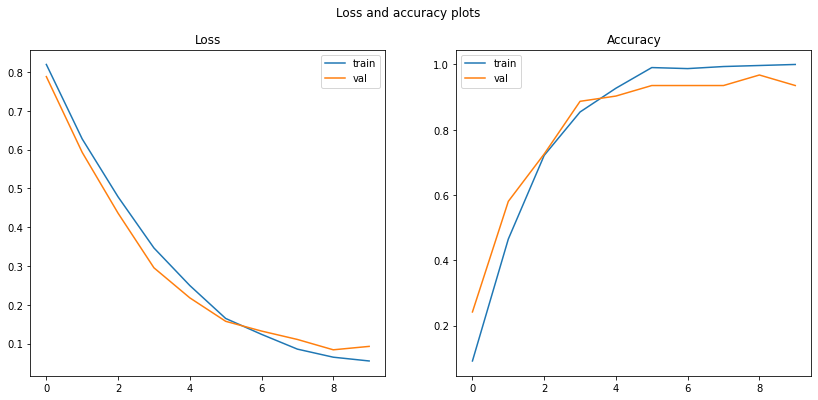

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
fig.suptitle('Loss and accuracy plots')

ax1.set_title('Loss')
ax1.plot(history['train_loss'],label='train')
ax1.plot(history['val_loss'],label='val')
ax1.legend()

ax2.set_title('Accuracy')
ax2.plot(history['train_acc'],label='train')
ax2.plot(history['val_acc'],label='val')
ax2.legend();
# fig.savefig('eda/history_shuffle.jpg',dpi=300)

In [20]:
for name,loader,y_true in zip(['train','test'],[train_loader_no_shuffle,test_loader],[index_df.class_id.values,test_df.class_id.values]):
    y_pred = predict(model,loader)
    print(f"{name} set: acc: {accuracy_score(y_true-1,y_pred):.4f} f1:{f1_score(y_true-1,y_pred,average='macro'):.4f}")

train set: acc: 1.0000 f1:1.0000
test set: acc: 0.9516 f1:0.9479


### Shuffle False

In [12]:
if 'model' in locals():
    del model
# model = init_model(32)
# model = init_model_resnet18(32)
model = init_model_mobilenet_v2(32)
model.to(device);


Using cache found in /home/eddiekro/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
#results were lost
history = training_loop(10,train_loader_no_shuffle,[test_loader], optimizer, criterion,lr=0.001)

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
fig.suptitle('Loss and accuracy plots')

ax1.set_title('Loss')
ax1.plot(history['train_loss'],label='train')
ax1.plot(history['val_loss'],label='val')
ax1.legend()

ax2.set_title('Accuracy')
ax2.plot(history['train_acc'],label='train')
ax2.plot(history['val_acc'],label='val')
ax2.legend()
# fig.savefig('eda/histoy_no_shuffle.jpg',dpi=300)

In [50]:
for name,loader,y_true in zip(['train','test'],[train_loader_no_shuffle,test_loader],[index_df.class_id.values,test_df.class_id.values]):
    y_pred = predict(model,loader)
    print(f"{name} set: acc: {accuracy_score(y_true-1,y_pred):.4f} f1:{f1_score(y_true-1,y_pred,average='macro'):.4f}")

train set: acc: 1.0000 f1:1.0000
test set: acc: 0.8387 f1:0.8354


### No normalization

In [10]:
# First results; batch_size 16, image size (512,512), no normalization/augmentations
training_loop(25,train_loader,[test_loader], optimizer, criterion,lr=0.0001)

epoch: 0

Train: Average loss: 0.2405	 Accuracy: 0.0127
Test set: Average loss: 0.2212	 Accuracy: 0.0968

epoch: 1

Train: Average loss: 0.1912	 Accuracy: 0.2627
Test set: Average loss: 0.2018	 Accuracy: 0.2742

epoch: 2

Train: Average loss: 0.1642	 Accuracy: 0.5791
Test set: Average loss: 0.1859	 Accuracy: 0.3387

epoch: 3

Train: Average loss: 0.1404	 Accuracy: 0.8449
Test set: Average loss: 0.1707	 Accuracy: 0.4032

epoch: 4

Train: Average loss: 0.1194	 Accuracy: 0.9620
Test set: Average loss: 0.1579	 Accuracy: 0.5645

epoch: 5

Train: Average loss: 0.1009	 Accuracy: 0.9905
Test set: Average loss: 0.1497	 Accuracy: 0.6613

epoch: 6

Train: Average loss: 0.0859	 Accuracy: 1.0000
Test set: Average loss: 0.1372	 Accuracy: 0.6774

epoch: 7

Train: Average loss: 0.0717	 Accuracy: 1.0000
Test set: Average loss: 0.1263	 Accuracy: 0.7258

epoch: 8

Train: Average loss: 0.0590	 Accuracy: 1.0000
Test set: Average loss: 0.1200	 Accuracy: 0.7419

epoch: 9

Train: Average loss: 0.0483	 Accurac

In [11]:
for name,loader,y_true in zip(['train','test'],[train_loader,test_loader],[index_df.class_id.values,test_df.class_id.values]):
    y_pred = predict(model,loader)
    print(f"{name} set: acc: {accuracy_score(y_true-1,y_pred):.4f} f1:{f1_score(y_true-1,y_pred,average='macro'):.4f}")
#     print(classification_report(y_true-1,y_pred))

train set: acc: 0.9968 f1:0.9969
test set: acc: 0.7581 f1:0.7452
